In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

2021-09-15 06:38:57.786947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
test_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [3]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [4]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [5]:
def load_dicom(path, size = 64): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [6]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join("../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [7]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [8]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [9]:
IMAGE_SIZE = 64

X, y, train_idt = get_all_data_train("T2w")
X_test, test_idt = get_all_data_test("T2w")
X.shape, y.shape, train_idt.shape

100%|██████████| 87/87 [00:32<00:00,  2.65it/s]


((16813, 64, 64), (16813,), (16813,))

In [10]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.15)

In [11]:
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

2021-09-15 06:43:49.329454: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 06:43:49.332879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-15 06:43:49.372251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 06:43:49.372954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-15 06:43:49.373017: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-15 06:43:49.400293: I tensorflow/stream_executor/platform/def

In [12]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape

(TensorShape([14291, 64, 64, 1]),
 (14291, 2),
 TensorShape([2522, 64, 64, 1]),
 (2522, 2),
 (14291,),
 (2522,))

In [13]:
def create_model():
    model = keras.Sequential()
    model.add(ResNet50(include_top=True, weights=None, input_shape=(64, 64, 1), classes=2))
    return model

In [14]:
## Hyper Parameters
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = 14291
N_VAL = 2522

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [15]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

In [16]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

2021-09-15 06:43:54.776628: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-15 06:43:54.788583: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000194999 Hz


Epoch 1/20


2021-09-15 06:43:59.716937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-15 06:44:00.452017: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-15 06:44:00.484256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


357/357 [==============================] - 30s 54ms/step - loss: 0.9599 - auc: 0.5582 - val_loss: 0.8172 - val_auc: 0.6265
Epoch 2/20
357/357 [==============================] - 17s 47ms/step - loss: 0.6978 - auc: 0.6503 - val_loss: 0.7075 - val_auc: 0.6624
Epoch 3/20
357/357 [==============================] - 17s 48ms/step - loss: 0.6189 - auc: 0.7342 - val_loss: 0.6293 - val_auc: 0.6976
Epoch 4/20
357/357 [==============================] - 17s 47ms/step - loss: 0.5421 - auc: 0.8053 - val_loss: 0.6017 - val_auc: 0.7532
Epoch 5/20
357/357 [==============================] - 17s 48ms/step - loss: 0.4322 - auc: 0.8812 - val_loss: 0.8156 - val_auc: 0.7175
Epoch 6/20
357/357 [==============================] - 17s 47ms/step - loss: 0.3324 - auc: 0.9322 - val_loss: 0.5512 - val_auc: 0.8323
Epoch 7/20
357/357 [==============================] - 17s 48ms/step - loss: 0.2618 - auc: 0.9583 - val_loss: 0.5608 - val_auc: 0.8437
Epoch 8/20
357/357 [==============================] - 17s 47ms/step - los

In [17]:
# Save the entire model to a HDF5 file
model.save('model.h5')

In [18]:
# Recreate the exact same model, including its weights and the optimizer
new_model = keras.models.load_model('model.h5')
# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2)                 23585538  
Total params: 23,585,538
Trainable params: 23,532,418
Non-trainable params: 53,120
_________________________________________________________________


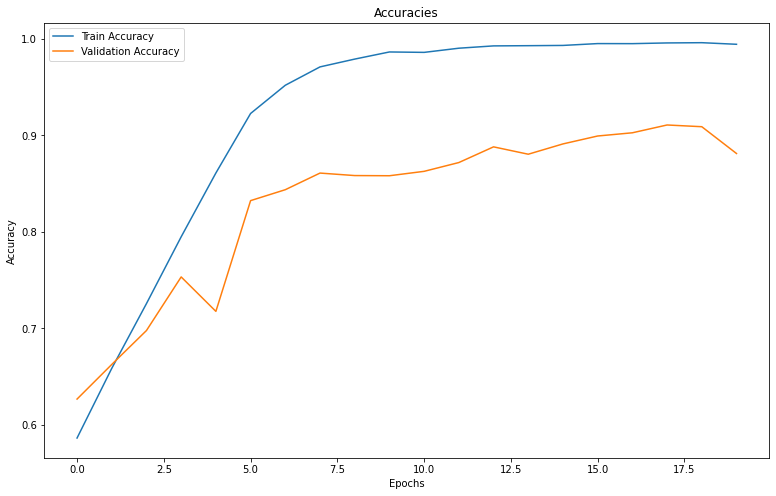

In [19]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc"], label = "Train Accuracy")
plt.plot(history.history["val_auc"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

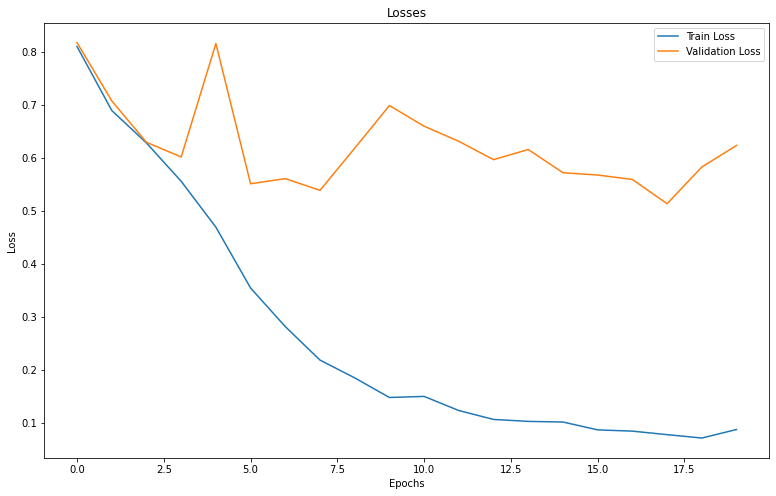

In [20]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]

In [22]:
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

0.767909748829289

In [24]:
X_test2 = tf.expand_dims(X_test, axis=-1)

In [25]:
#submission
sample_sub = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

y_pred = model.predict(X_test2) #predict test
pred = np.argmax(y_pred, axis = 1)

result = pd.DataFrame(test_idt)
result[1] = pred

result.columns=["BraTS21ID","MGMT_value"]
result_final = result.groupby("BraTS21ID",as_index = False).mean()

result_final["BraTS21ID"] = sample_sub["BraTS21ID"]
result_final["MGMT_value"] = result_final["MGMT_value"]
result_final

,BraTS21ID,MGMT_value
0,1,0.136364
1,13,0.220588
2,15,0.838235
3,27,0.363636
4,37,0.309859
...,...,...
82,826,0.000000
83,829,0.600000
84,833,0.166667
85,997,0.000000


In [26]:
result_final.to_csv("submission.csv",index=False)